# Import section

---
# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.





In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

import pickle
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
import math
import glob 
from PIL import Image

# Check the tensor flow version
print(tf.__version__)

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the root directory for the project

root_dir = '/content/drive/MyDrive/Colab Notebooks/CarND-Traffic-Sign-Classifier-Project/'

# training and testing data
training_file = root_dir + 'data/train.p'
validation_file= root_dir + 'data/valid.p'
testing_file = root_dir + 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

# Check the data sanity
assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))


## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = x_train.shape[0]

# Number of validation examples
n_validation = x_valid.shape[0]

# Number of testing examples.
n_test = x_test.shape[0]

# Shape of image
image_shape = x_train.shape[1:3]

# Unique classes/labels there are in the dataset.
n_classes = len(list(set(train['labels'])))

print("Number of training examples =", n_train)
print("Number of validating examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


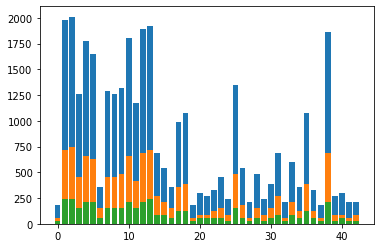

In [5]:
# Read the CVS file with the ClassId's and the signal names
signals = pd.read_csv(root_dir + 'signnames.csv')

def plt_bar_dataset(y_train, y_test, y_valid):
  # Explore the training dataset
  train_values, train_counts = np.unique(y_train, return_counts = True)
  plt.bar(train_values, train_counts)
  # Explore the test dataset
  test_values, test_counts = np.unique(y_test, return_counts = True)
  plt.bar(test_values, test_counts)
  # Explore the test dataset
  valid_values, valid_counts = np.unique(y_valid, return_counts = True)
  plt.bar(valid_values, valid_counts)

  return train_counts, test_counts, valid_counts

#Plor the original distribution of the data set
train_counts = plt_bar_dataset(y_train, y_test, y_valid)

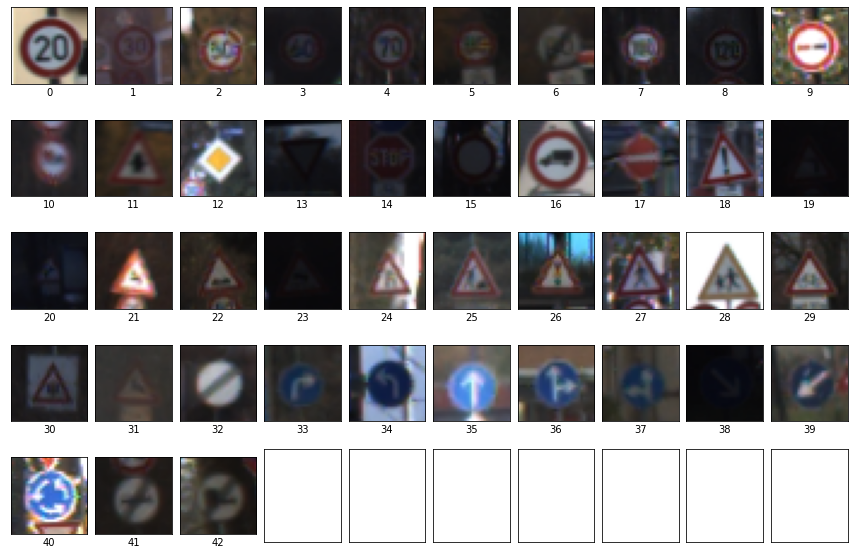

In [6]:

# Represent the first ocurrence on the train dataser of each classes (signals)

def plot_images(images, labels):  
  fig, axes = plt.subplots(5, 10 , figsize = (15 , 10))
  fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
  for idx, ax in enumerate(axes.flat):
        if idx < n_classes:
          ax.imshow(images[idx])
          xlabel = "{0}".format(idx)
          ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])    
  plt.show()

# Obtain the index of the first ocurrence for each signal
idxes = []
for sign in range(n_classes):
  idx = (np.where(y_train == sign)[0][0])
  idxes.append(idx)        

# Plot one image for each class and the label
plot_images(x_train[idxes], signals['SignName'])

## Step 2: Design and Test a Model Architecture

### Preprocessing

In [7]:
def apply_grayscale(img):
  """
  Apply grayscale transformation using openCV function (cvtColor)
    
  Parameters:
    img (numpy.ndarray): Color image

  Returns:
    img (numpy.ndarray): Grayscaled image    
  """
  shape = img.shape
  img = np.array(img, dtype = np.uint8)    
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = gray[: , :, np.newaxis]
  return gray

def apply_clahe(img):
  """
  Apply CLAHE (Adaptive histogram equalization) to the image (img)
    
  Parameters:
    img (numpy.ndarray): Grayscaled image (unint8)

  Returns:
    img (numpy.ndarray): Equalizated image    
  """    
  clahe = cv2.createCLAHE(clipLimit = 4.0, tileGridSize = (4, 4))
  clahe_img = clahe.apply(img)
  return clahe_img

def apply_normalize(img):
  """
  Normalize the image to (-1, 1) range. (other methods can be used like mean/std ...etc.)
  
  Parameters:
    img (numpy.ndarray): Grayscaled image (unint8)
  Returns:
    img (numpy.ndarray): Normalized image    
  """   
  return (img - 128.) / 128.


def preprocessing(images):    
  """
  Pre-process pipeline: grayscale transformation, equilization and normalization
  
  Parameters:
    images (numpy.ndarray): (dim(images), 32, 32, 3)
  Returns:
    batch (numpy.ndarray): (dim(images), 32, 32, 1)
  """      
  shape = images.shape 
  out_img_shape=(shape[1],shape[2],1)
  batch = np.zeros((shape[0],shape[1],shape[2],1))
    
  for i in range(len(images)):
    gray = apply_grayscale(images[i,:]  )        
    clahe = apply_clahe(gray).reshape(out_img_shape)
    norm = apply_normalize(clahe)        
    batch[i] = norm
  
  return batch


In [8]:
x_train = preprocessing(x_train)
x_valid = preprocessing(x_valid)
x_test = preprocessing(x_test)

In [10]:

def augment_dataset(x_dataset, y_dataset, min_occurrence):
  # Configure the image generator to create rescaled, shifted, rotated or zomm images (not flipped -> numbers and letters)
  train_gen = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range = random.uniform(-0.4, 0.4),
                                                              rotation_range = random.uniform(-15., 15.), 
                                                              zoom_range = [random.uniform(0.7, 0.7),random.uniform(0.9, 0.9)], dtype = np.uint8 )

  # For each class (sign) check the number of ocurrences and complete as needed
  for sign_class in range(n_classes):
    # Prepare x for the first iteration
    x = x_dataset[y_dataset == sign_class]
    # Init for each class
    x_dataset_augmented = np.zeros([1,32,32,3])
    y_dataset_augmented = np.zeros([1])

    while ((min_occurrence - len(x)) > 0):
      it = train_gen.flow(x = x, y = None,
                          batch_size = min_occurrence - len(x),
                          shuffle = True)
      batch = it.next()
      # Update x to the next iteration
      x = np.concatenate((x, x_dataset_augmented), axis = 0)
      # Store augmented data 
      x_dataset_augmented = np.concatenate((x_dataset_augmented, batch), axis = 0)
      y_dataset_augmented = np.concatenate((y_dataset_augmented, np.full(batch.shape[0], sign_class)))      

    # Update the data set
    x_dataset = np.concatenate((x_dataset, x_dataset_augmented), axis = 0)
    y_dataset = np.concatenate((y_dataset, y_dataset_augmented), axis = 0)

  return x_dataset, y_dataset

In [ ]:
# Minimun number of ocurrence per class
min_occurrence = np.uint16(np.amax(train_counts) * 0.25)

# Augment dataset (training)
x_train, y_train = augment_dataset(x_train, y_train, min_occurrence)

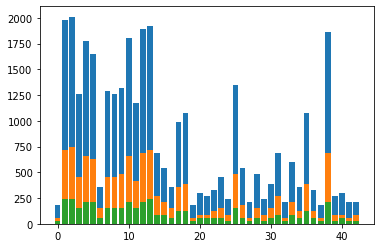

In [ ]:
train_counts = plt_bar_dataset(y_train, y_test, y_valid)

In [12]:

# Parameters
conv1_filters = 6
conv2_filters = 16
fc1_units = 120
fc2_units = 84
num_classes = n_classes

# Architecture
model = models.Sequential()
# Layers
# Convolutional layers
model.add(layers.Conv2D(conv1_filters, (5, 5), activation = 'relu', input_shape = (32, 32, 1)))
model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'SAME'))
model.add(layers.Conv2D(conv2_filters, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'SAME'))
# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(fc1_units, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(fc2_units, activation = 'relu'))
model.add(layers.Dropout(rate = 0.5))

model.add(layers.Dense(num_classes))


In [13]:
# Compile the ConvNet

opt = optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)              

In [15]:

# Use tf.data API to shuffle and batch data.
batch_size = 128
epochs = 100 

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(len(x_train)).batch(batch_size).prefetch(1)

# Train model
history = model.fit(train_data, epochs = epochs, steps_per_epoch = math.ceil(len(x_train) / batch_size),
                   validation_data=(x_valid, y_valid))

Epoch 1/100
272/272 [==============================] - 3s 5ms/step - loss: 3.1760 - accuracy: 0.1709 - val_loss: 0.9729 - val_accuracy: 0.7295
Epoch 2/100
272/272 [==============================] - 1s 4ms/step - loss: 1.1704 - accuracy: 0.6371 - val_loss: 0.4585 - val_accuracy: 0.8608
Epoch 3/100
272/272 [==============================] - 1s 4ms/step - loss: 0.6869 - accuracy: 0.7773 - val_loss: 0.3039 - val_accuracy: 0.9007
Epoch 4/100
272/272 [==============================] - 1s 4ms/step - loss: 0.5049 - accuracy: 0.8398 - val_loss: 0.2694 - val_accuracy: 0.9075
Epoch 5/100
272/272 [==============================] - 1s 4ms/step - loss: 0.4086 - accuracy: 0.8698 - val_loss: 0.2225 - val_accuracy: 0.9297
Epoch 6/100
272/272 [==============================] - 1s 4ms/step - loss: 0.3492 - accuracy: 0.8865 - val_loss: 0.2089 - val_accuracy: 0.9349
Epoch 7/100
272/272 [==============================] - 1s 4ms/step - loss: 0.3114 - accuracy: 0.9009 - val_loss: 0.2098 - val_accuracy: 0.9379

First:


---


Preprocessing: None

Augmnetation: None

Epoch 40/40
1088/1088 [==============================] - 3s 3ms/step - loss: 0.4410 - accuracy: 0.8919 - val_loss: 0.4222 - val_accuracy: 0.8973

395/395 [==============================] - 1s 2ms/step - loss: 0.4488 - accuracy: 0.9172
Accuracy on test dataset: 0.9171813130378723


Second


---

Preprocessing: Grayscale + equialization + normalization

Augmnetation: None


Epoch 40/40
1088/1088 [==============================] - 3s 3ms/step - loss: 0.0808 - accuracy: 0.9765 - val_loss: 0.1071 - val_accuracy: 0.9776

395/395 [==============================] - 1s 2ms/step - loss: 0.3126 - accuracy: 0.9496
Accuracy on test dataset: 0.949564516544342


In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, steps = math.ceil(len(x_test)/batch_size))
print('Accuracy on test dataset:', test_accuracy)

99/99 [==============================] - 0s 2ms/step - loss: 0.2816 - accuracy: 0.9602
Accuracy on test dataset: 0.9601742029190063


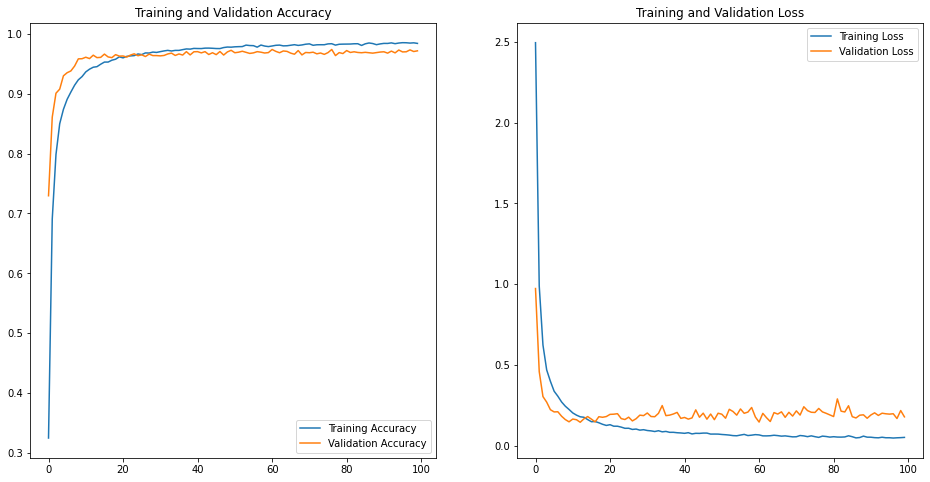

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

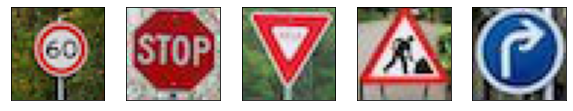

In [18]:

images = [plt.imread(fname) for fname in glob.glob(root_dir + 'data/' + '*.jpg')]

plt.figure(figsize=(10,10))
for step, img in enumerate(images):
    plt.subplot(5, 5, step + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

In [ ]:

images = np.array(images)
images = preprocessing(images)
p = model.predict(images)

plt.figure(figsize=(14,14))

for step, img in enumerate(images):
    plt.subplot(5, 5, step + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(image_shape), cmap = 'gray')
    plt.xlabel(signals['SignName'][np.argmax(p[step])])

In [32]:
values, indices = tf.nn.top_k(tf.nn.softmax(p),5, sorted=True)

tf.Tensor(
[[3.2440615e-01 2.8178096e-01 1.9721675e-01 7.9439096e-02 3.8519789e-02]
 [9.2862022e-01 4.2168543e-02 2.7018975e-02 1.6220370e-03 2.0844235e-04]
 [1.0000000e+00 4.0764744e-28 5.3762001e-34 1.7348991e-37 0.0000000e+00]
 [9.9868232e-01 6.8329665e-04 3.4829555e-04 2.4358070e-04 2.5215651e-05]
 [9.9999917e-01 8.7477861e-07 6.3755277e-09 2.5649833e-09 6.6943384e-10]], shape=(5, 5), dtype=float32) tf.Tensor(
[[ 3 23  5 38 29]
 [14  3 36 34 35]
 [13 35 12 34  0]
 [18  1 25 11 40]
 [33 37 14 13 35]], shape=(5, 5), dtype=int32)


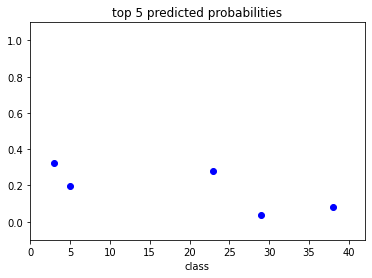

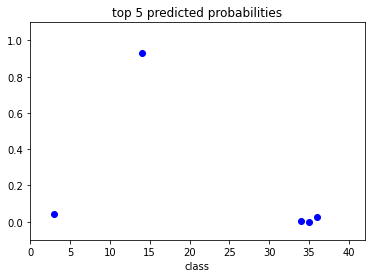

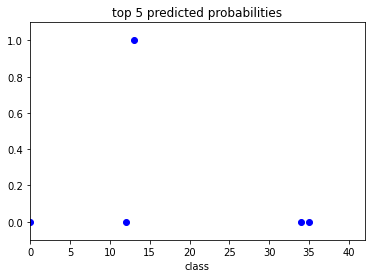

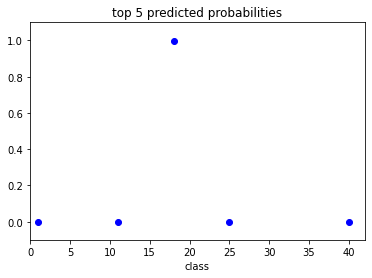

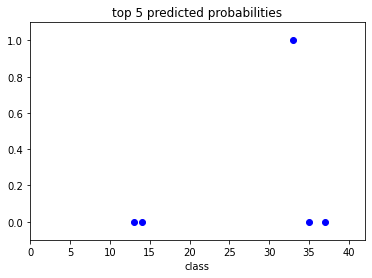

In [41]:
print(values, indices)

for i in range(5):
  y0 = values[i,:]
  x0 = indices[i,:]
  plt.scatter(x0,y0,color="blue")
  plt.title('top 5 predicted probabilities')
  plt.xlabel('class')
  plt.xlim([0,42])
  plt.ylim([-0.1,1.1])
  plt.show()

